In [1]:
import sys

base_path = '/Users/yuri/git/diasYuri/tcc/radiation-forecast-mg'
sys.path.insert(0, base_path)

In [2]:
from src.filler import RandomForestFiller, RandomForestFillerWithOneModel, Debbuger, fill_df
from src.dataframe import read_data, windowing, show_error_metrics, split_data
from src.scaler import Scaler
from src.model import build_model, hp_search

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, InputLayer
from keras.callbacks import EarlyStopping

from sklearn.ensemble import RandomForestRegressor


Using TensorFlow backend


In [3]:
df = read_data(f'{base_path}/data/daily_barbacena.csv')
df

,RADIATION,TEMP,HUMIDITY_h
Timestamp,,,
2003-03-21,17306.0,20.329167,81.375000
2003-03-22,10357.0,19.037500,88.250000
2003-03-23,10708.0,18.029167,89.250000
2003-03-24,12355.0,18.520833,87.958333
2003-03-25,19740.0,19.262500,80.958333
...,...,...,...
2022-12-27,13899.2,18.629167,88.958333
2022-12-28,10267.3,19.625000,88.500000
2022-12-29,8122.0,19.362500,92.208333


In [4]:
print(df.isna().sum())

filler = RandomForestFillerWithOneModel(n_estimators=1000, n_in=5, n_out=1)
data = {}
for column in df.columns:
    data[column] = filler.filler(df[column])
data =  pd.DataFrame(data=data, index=df.index.values)

print(data.isna().sum())

RADIATION     273
TEMP          326
HUMIDITY_h    667
dtype: int64
RADIATION     0
TEMP          0
HUMIDITY_h    0
dtype: int64


In [5]:
dir = f'{base_path}/data-temp/lstm_with_random_forest_filler'
os.makedirs(dir, exist_ok=True)  
data.to_csv(f'{dir}/data_filled.csv')  

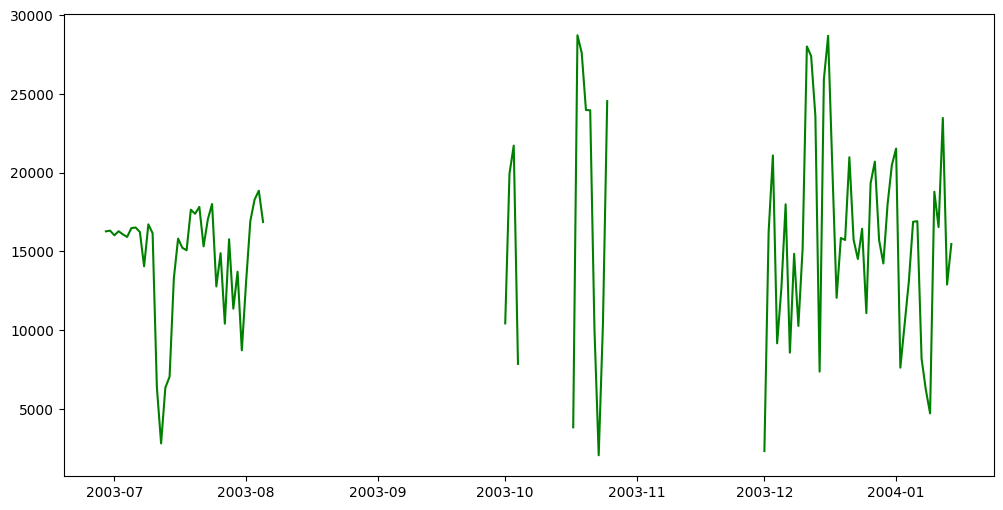

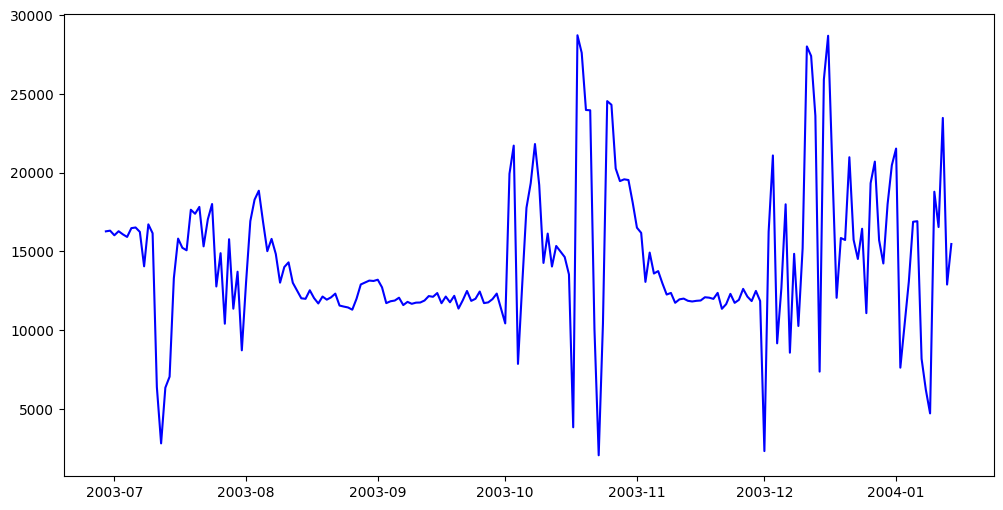

In [6]:
init = 100
m_range = 200

plt.figure(figsize=(12, 6))
plt.plot(df.RADIATION[init:init+m_range], color='green')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data.RADIATION[init:init+m_range], color='blue')
plt.show()

In [7]:
scaler = Scaler(data)
df_scaled = scaler.get_dataframe_scaled()
print(data, df_scaled)

            RADIATION       TEMP  HUMIDITY_h
2003-03-21    17306.0  20.329167   81.375000
2003-03-22    10357.0  19.037500   88.250000
2003-03-23    10708.0  18.029167   89.250000
2003-03-24    12355.0  18.520833   87.958333
2003-03-25    19740.0  19.262500   80.958333
...               ...        ...         ...
2022-12-27    13899.2  18.629167   88.958333
2022-12-28    10267.3  19.625000   88.500000
2022-12-29     8122.0  19.362500   92.208333
2022-12-30     7987.6  18.958333   93.458333
2022-12-31    12501.4  18.854167   90.083333

[7226 rows x 3 columns]             RADIATION      TEMP  HUMIDITY_h
2003-03-21   0.543153  0.600381    0.768722
2003-03-22   0.324396  0.536135    0.855255
2003-03-23   0.335446  0.485983    0.867841
2003-03-24   0.387294  0.510437    0.851584
2003-03-25   0.619777  0.547327    0.763478
...               ...       ...         ...
2022-12-27   0.435906  0.515826    0.864170
2022-12-28   0.321572  0.565357    0.858402
2022-12-29   0.254037  0.552300    0.90

In [8]:
X, Y = windowing(df_scaled, 'RADIATION', 5, 1)
train_x, train_y, test_x, test_y = split_data(X, Y, length=len(df_scaled), ratio=0.9)

In [9]:
hp = hp_search('randomforest_lstm_5_1_barbacena', train_x, train_y, 
               max_trials=20, 
               executions_per_trial=2, 
               epochs=15, 
               validation_split=0.3,
               directory=f'{base_path}/notebook/models')
hp.values

Search space summary
Default search space size: 7
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
dropout (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
activation_o (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


{'units': 160,
 'activation_1': 'relu',
 'dropout': 0.0,
 'units_2': 512,
 'activation_2': 'relu',
 'activation_o': 'sigmoid',
 'learning_rate': 0.01}

Epoch 1/200
91/91 - 3s - loss: 0.0266 - val_loss: 0.0232 - 3s/epoch - 31ms/step
Epoch 2/200
91/91 - 2s - loss: 0.0226 - val_loss: 0.0227 - 2s/epoch - 22ms/step
Epoch 3/200
91/91 - 2s - loss: 0.0217 - val_loss: 0.0214 - 2s/epoch - 22ms/step
Epoch 4/200
91/91 - 2s - loss: 0.0216 - val_loss: 0.0219 - 2s/epoch - 22ms/step
Epoch 5/200
91/91 - 2s - loss: 0.0210 - val_loss: 0.0240 - 2s/epoch - 22ms/step
Epoch 6/200
91/91 - 2s - loss: 0.0216 - val_loss: 0.0215 - 2s/epoch - 22ms/step
Epoch 7/200
91/91 - 2s - loss: 0.0218 - val_loss: 0.0230 - 2s/epoch - 23ms/step
Epoch 8/200
91/91 - 2s - loss: 0.0213 - val_loss: 0.0195 - 2s/epoch - 23ms/step
Epoch 9/200
91/91 - 2s - loss: 0.0213 - val_loss: 0.0239 - 2s/epoch - 23ms/step
Epoch 10/200
91/91 - 2s - loss: 0.0210 - val_loss: 0.0215 - 2s/epoch - 22ms/step
Epoch 11/200
91/91 - 2s - loss: 0.0210 - val_loss: 0.0207 - 2s/epoch - 23ms/step
Epoch 12/200
91/91 - 2s - loss: 0.0211 - val_loss: 0.0213 - 2s/epoch - 23ms/step
Epoch 13/200
91/91 - 2s - loss: 0.020

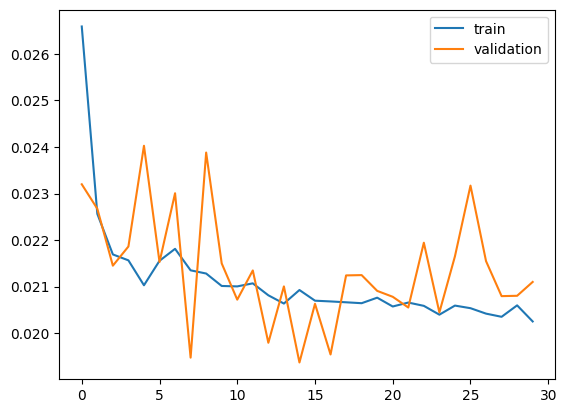

In [10]:
model = build_model(hp)

# fit network
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history = model.fit(train_x,
                    train_y,
                    epochs=200,
                    batch_size=72,
                    validation_data=(test_x, test_y),
                    validation_split=0.3,
                    verbose=2,
                    callbacks=[es],
                    workers=4,
                    use_multiprocessing=True)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [11]:
predict = model.predict(test_x)

show_error_metrics(test_y.reshape(-1,1), predict)

real = scaler.scales['RADIATION'].inverse_transform(test_y.reshape(-1,1))
predict = scaler.scales['RADIATION'].inverse_transform(predict)

23/23 [==============================] - 0s 7ms/step
Test R2: 0.453
Test MSE: 0.021
Test RMSE: 0.145
Test MAE: 0.117
Test MAPE: 0.394


Test R2: 0.453
Test MSE: 21291554.595
Test RMSE: 4614.277
Test MAE: 3717.707
Test MAPE: 0.391


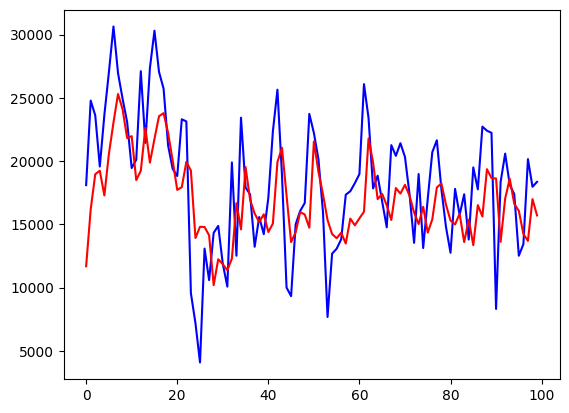

In [12]:
range_plot = 100

plt.plot(real[0:range_plot], color='blue', label='real')
plt.plot(predict[0:range_plot], color='red', label='incompleto')

show_error_metrics(real, predict)

plt.show()